In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys
import copy
sys.path.insert(1, "../data")

In [2]:
data = scipy.io.loadmat("../data/sampleEEGdata.mat")

chanlocs = [data["EEG"]['chanlocs'][0][0][0][i][0] for i in range(64)]
srate = int(data["EEG"]["srate"])
dataE = data["EEG"][0][0][15]
times = np.squeeze(data["EEG"][0][0][14])
pnts = dataE.shape[1]

channel2use = "PO7"
chanidx = chanlocs.index(channel2use)

eegNPL = copy.deepcopy(dataE)

for chani in range(len(chanlocs)):
    thisChanERP = np.mean(dataE[chani,:,:], axis=1)
    thisChanERP = np.expand_dims(thisChanERP, axis=1)  
    thisChanERP = np.tile(thisChanERP, (1, 99)) 

    eegNPL[chani,:,:] = eegNPL[chani,:,:] - thisChanERP

C:\Users\kerem\AppData\Local\Temp\ipykernel_12000\2459961137.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  srate = int(data["EEG"]["srate"])


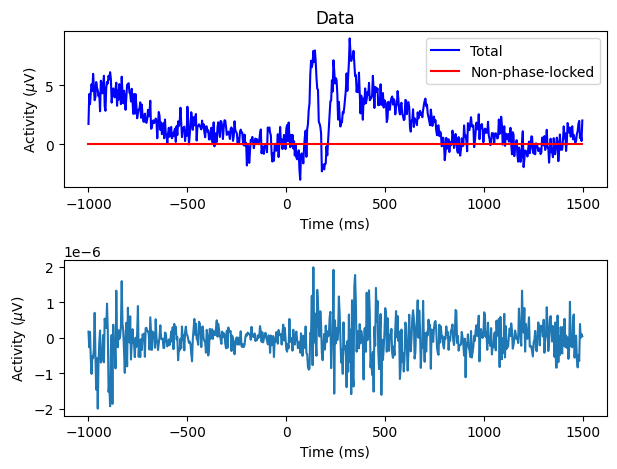

In [3]:
plt.subplot(211)
plt.plot(times.T, np.mean(dataE[chanidx,:,:], axis=1), "b", label="Total")
plt.plot(times.T, np.mean(eegNPL[chanidx,:,:], axis=1), "r", label="Non-phase-locked")
plt.xlabel("Time (ms)")
plt.ylabel("Activity ($\mu$V)")
plt.title("Data")
plt.legend()

plt.subplot(212)
plt.plot(times.T, np.mean(eegNPL[chanidx,:,:], axis=1))
plt.xlabel("Time (ms)")
plt.ylabel("Activity ($\mu$V)")
plt.tight_layout()

In [4]:
numFrex = 43
minFrex = 1.9
maxFrex = 40.1

frex = np.linspace(minFrex, maxFrex, numFrex)
time = np.arange(-1, 1, 1/srate)
half_wave = int((len(time) - 1) / 2)

nWave = len(time)
nData = dataE.shape[1] * dataE.shape[2]
nConv = nWave + nData - 1

baseidx = [int(np.argmin(abs(times+500))),int(np.argmin(abs(times+200))) ]

dataXTotal = scipy.fft.fft(np.reshape(dataE[chanidx,:,:],(1,nData), order="F"), nConv)
dataXNPL = scipy.fft.fft(np.reshape(eegNPL[chanidx,:,:],(1,nData), order="F"), nConv)

tf = np.zeros((2, numFrex, pnts, 2))

for fi in range(numFrex):
    fwhm = .3
    wavelet = np.exp(2*1j*np.pi*frex[fi]*time) * np.exp(-4*np.log(2)*time**2 / (fwhm**2))
    waveletX = scipy.fft.fft(wavelet, nConv)
 
    waveletX = waveletX / np.max(waveletX)
 
    as_ = scipy.fft.ifft(waveletX * dataXTotal, nConv)
    as_ = as_[0,half_wave:-half_wave-1]
    as_ = np.reshape(as_, (dataE.shape[1],dataE.shape[2]), order="F")
    
    basepow = np.mean(np.mean(abs(as_[baseidx[0]:baseidx[1],:]**2), 1))
    tf[0,fi,:,0] = 10*np.log10(np.mean(abs(as_**2), axis=1) / basepow)
    tf[0,fi,:,1] = abs(np.mean(np.exp(1j*np.angle(as_)), axis=1))

    as_ = scipy.fft.ifft(waveletX * dataXNPL, nConv)
    as_ = as_[0,half_wave:-half_wave-1]
    as_ = np.reshape(as_, (dataE.shape[1],dataE.shape[2]), order="F")

    basepow = np.mean(np.mean(abs(as_[baseidx[0]:baseidx[1],:]**2), 1))
    tf[1,fi,:,0] = 10*np.log10(np.mean(abs(as_**2), axis=1) / basepow)
    tf[1,fi,:,1] = abs(np.mean(np.exp(1j*np.angle(as_)), axis=1))

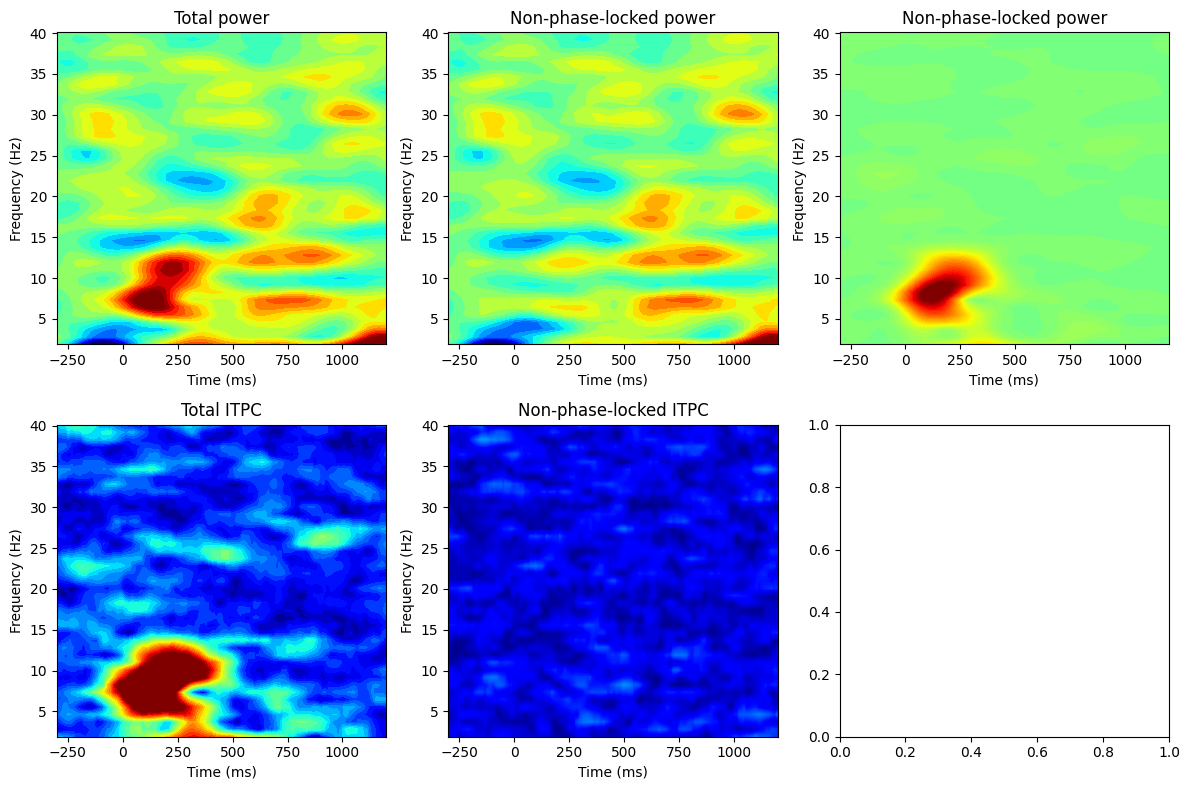

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

axs[0, 0].contourf(times, frex, np.squeeze(tf[0, :, :, 0]), 40, vmin=-3, vmax=3, cmap='jet')
axs[0, 0].set_xlim([-300, 1200])
axs[0, 0].set_xlabel('Time (ms)')
axs[0, 0].set_ylabel('Frequency (Hz)')
axs[0, 0].set_title('Total power')

axs[0, 1].contourf(times, frex, np.squeeze(tf[1, :, :, 0]), 40, vmin=-3, vmax=3, cmap='jet')
axs[0, 1].set_xlim([-300, 1200])
axs[0, 1].set_xlabel('Time (ms)')
axs[0, 1].set_ylabel('Frequency (Hz)')
axs[0, 1].set_title('Non-phase-locked power')

axs[0, 2].contourf(times, frex, np.squeeze(tf[0, :, :, 0]-tf[1, :, :, 0]), 40, vmin=-3, vmax=3, cmap='jet')
axs[0, 2].set_xlim([-300, 1200])
axs[0, 2].set_xlabel('Time (ms)')
axs[0, 2].set_ylabel('Frequency (Hz)')
axs[0, 2].set_title('Non-phase-locked power')

axs[1, 0].contourf(times, frex, np.squeeze(tf[0, :, :, 1]), 40, vmin=0, vmax=0.5, cmap='jet')
axs[1, 0].set_xlim([-300, 1200])
axs[1, 0].set_xlabel('Time (ms)')
axs[1, 0].set_ylabel('Frequency (Hz)')
axs[1, 0].set_title('Total ITPC')

axs[1, 1].contourf(times, frex, np.squeeze(tf[1, :, :, 1]), 40, vmin=0, vmax=0.5, cmap='jet')
axs[1, 1].set_xlim([-300, 1200])
axs[1, 1].set_xlabel('Time (ms)')
axs[1, 1].set_ylabel('Frequency (Hz)')
axs[1, 1].set_title('Non-phase-locked ITPC')

plt.tight_layout()
plt.show()